Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Train Ratio: 90%
MAE: 19.80
MSE: 623.90
RMSE: 24.98
MAPE: 41.56%
------------------------------


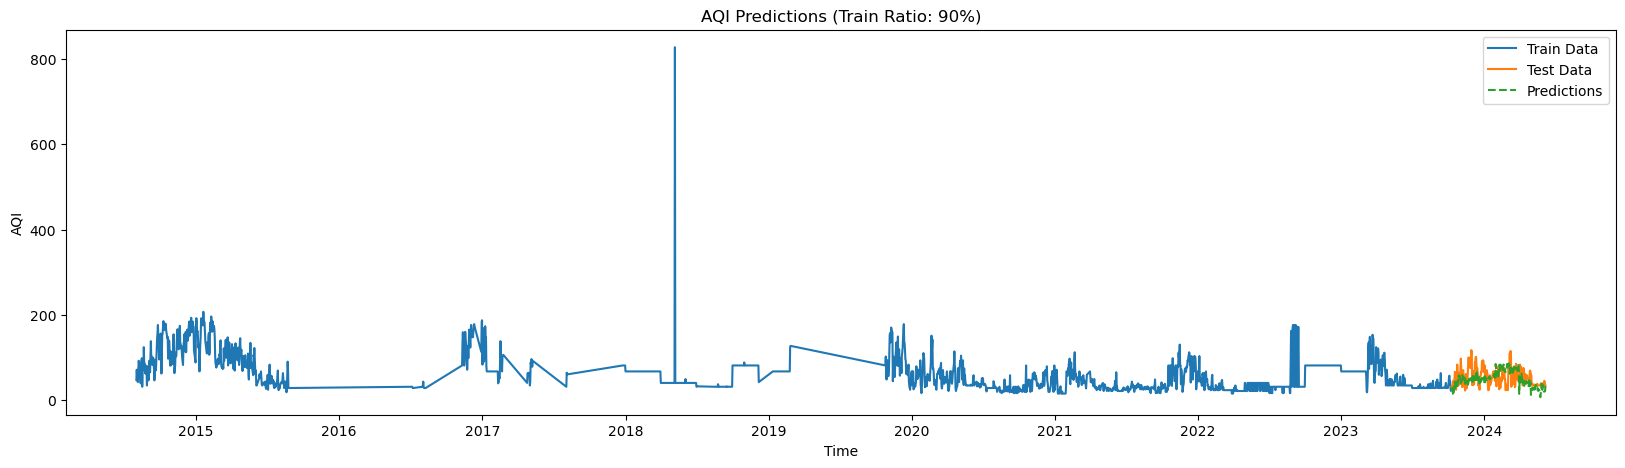

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Train Ratio: 80%
MAE: 26.06
MSE: 1013.19
RMSE: 31.83
MAPE: 63.62%
------------------------------


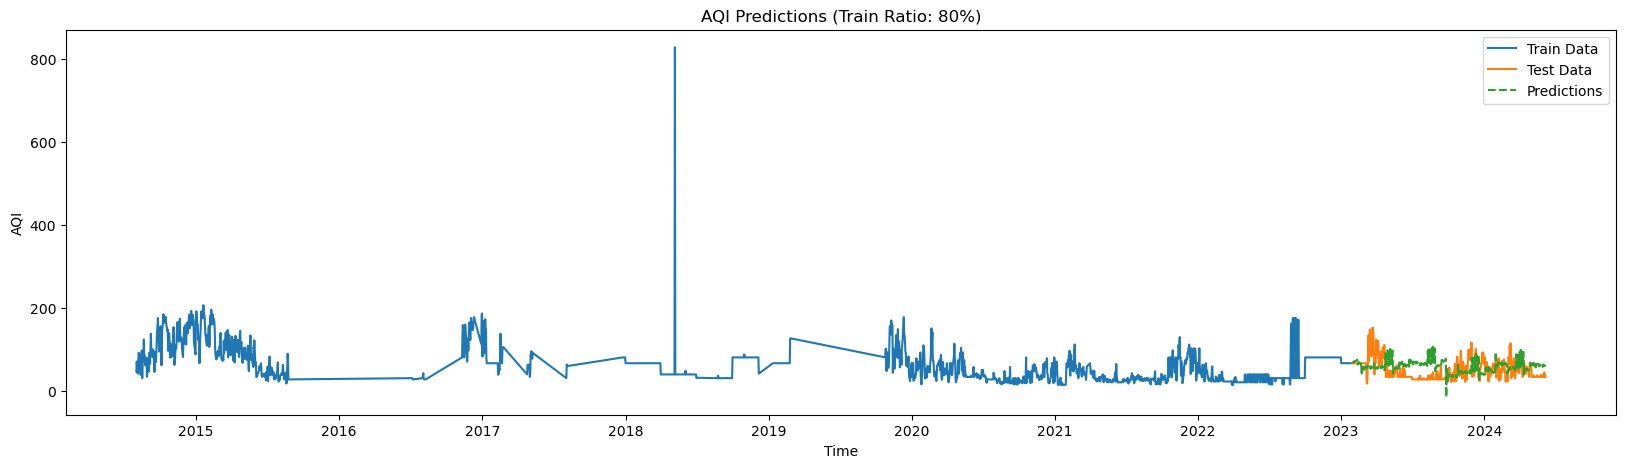

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Train Ratio: 70%
MAE: 40.87
MSE: 2522.03
RMSE: 50.22
MAPE: 72.03%
------------------------------


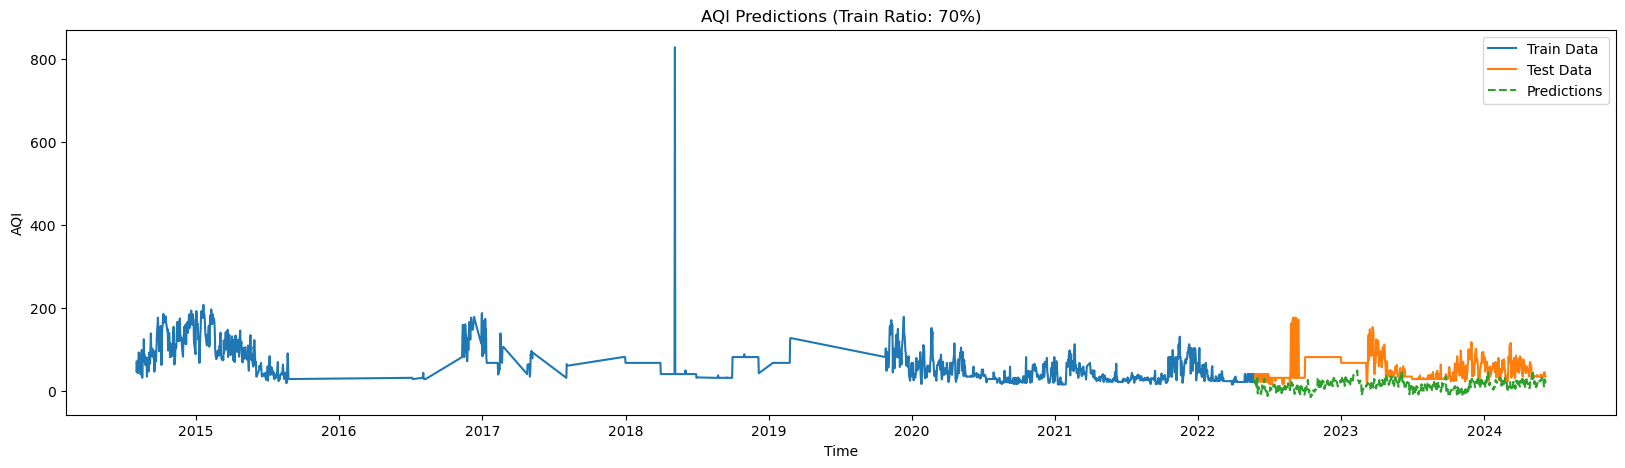

Best Train Ratio: 90%
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


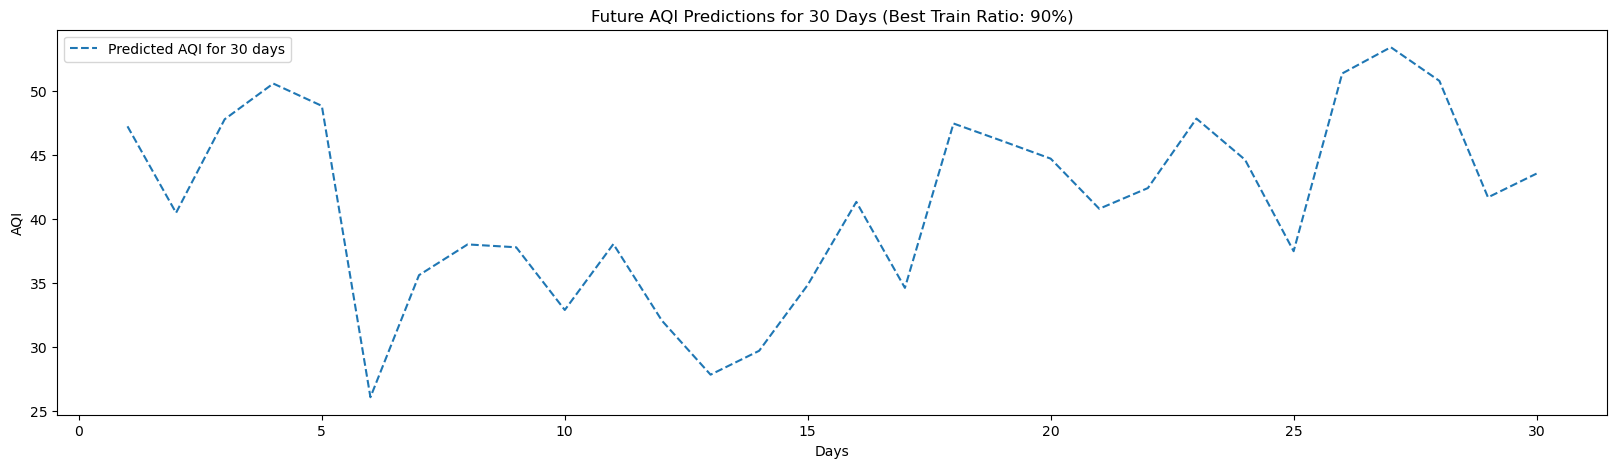

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


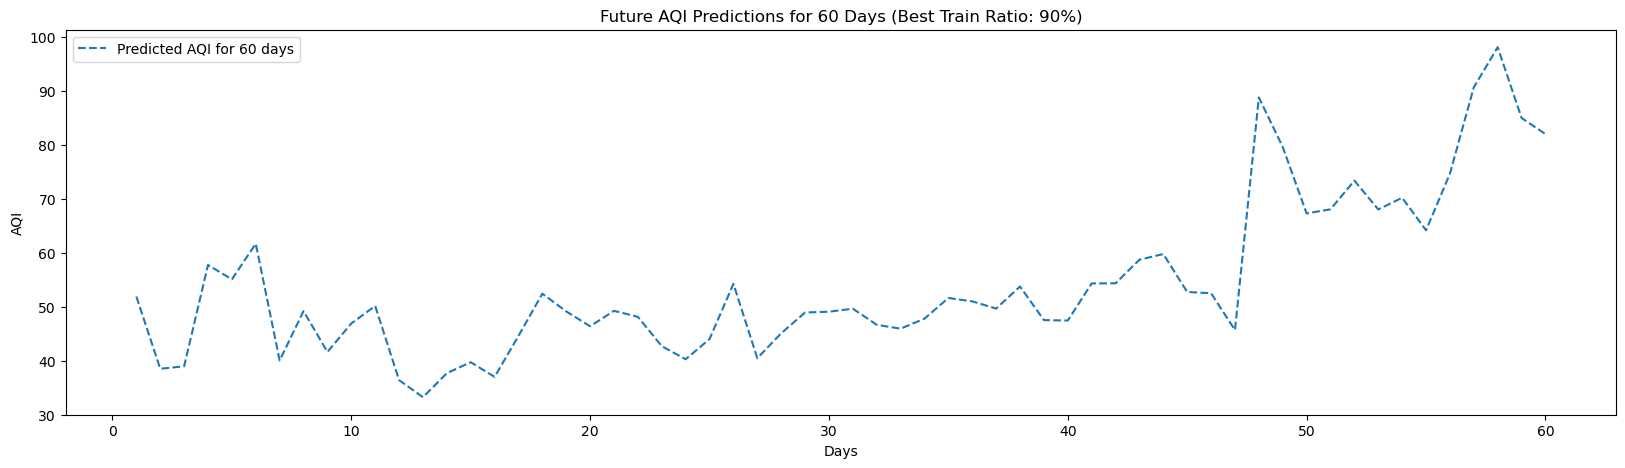

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


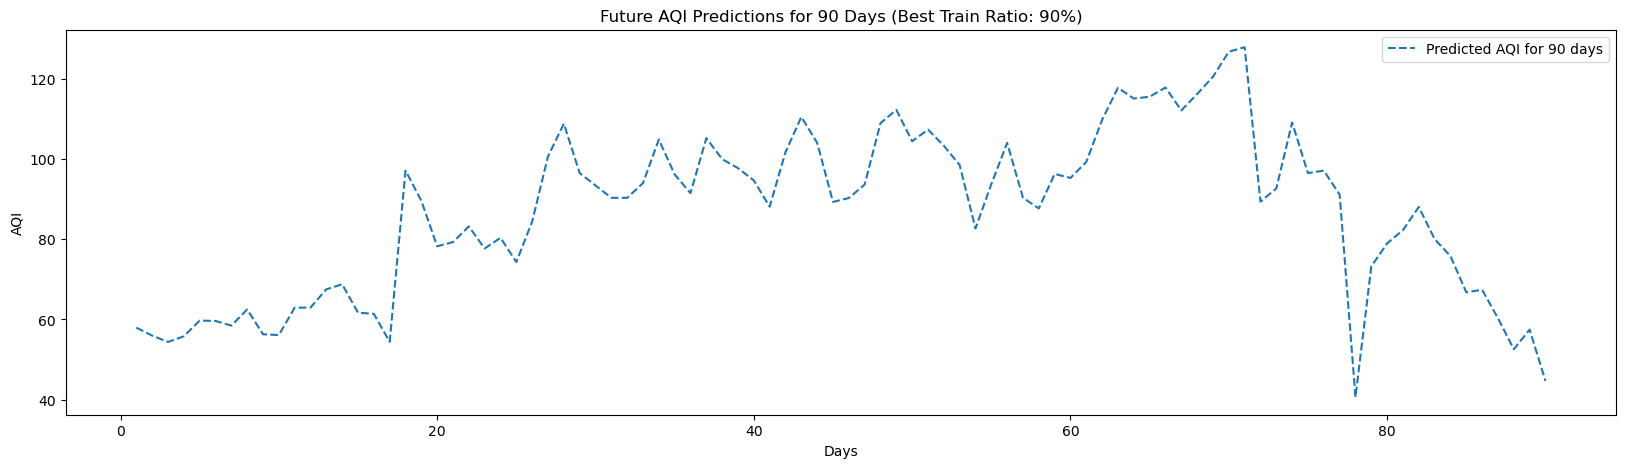

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pydlm import dlm, trend, seasonality, autoReg, longSeason
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Hàm tính MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Hàm chia, tính toán và train model
def evaluate_model(data, train_ratio):
     # Tính toán chia tỉ lệ train:test
    train_size = int(len(data) * train_ratio)
    
    # Chia dataset
    train, test = data[:train_size], data[train_size:]

    # Lấy ra chỉ số AQI của train và test
    train_values = train['AQI'].values
    test_values = test['AQI'].values

    # Xây dựng DLM model
    model = dlm(train_values)
    model = model + trend(degree=0, discount=0.99, name='linear_trend')
    model = model + seasonality(period=108, discount=0.99, name='yearly_seasonality')
    model = model + autoReg(degree = 3, discount=0.99, name='ar')
    model = model + longSeason(period=12, stay=30, data=data, name='monthly', w=1e7)
    model.fit()

    # Dự báo dựa trên test
    (predictions_mean, predictions_var) = model.predictN(N=len(test_values))
    predictions_mean = np.array(predictions_mean)

    # Tính toán chỉ số MAE, MSE, RMSE và MAPE
    mae = mean_absolute_error(test_values, predictions_mean)
    mse = mean_squared_error(test_values, predictions_mean)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(test_values, predictions_mean)

    return train_values, test_values, predictions_mean, mae, mse, rmse, mape

#Hàm vẽ đánh giá đồ thị
def plot_results(data, train_values, test_values, predictions, train_ratio):
    plt.figure(figsize=(20, 5))
    
    plt.plot(data.index[:len(train_values)], train_values, label='Train Data')

    plt.plot(data.index[len(train_values):len(train_values) + len(test_values)], test_values, label='Test Data')

    plt.plot(data.index[len(train_values):len(train_values) + len(test_values)], predictions, label='Predictions', linestyle='--')

    plt.xlabel('Time')
    plt.ylabel('AQI')
    plt.title(f'AQI Predictions (Train Ratio: {train_ratio*100:.0f}%)')
    plt.legend()
    plt.show()

#Hàm dự đoán tương lai
def predict_future(data, train_ratio, days):
    train_size = int(len(data) * train_ratio)
    train_test = data[:train_size + days]

    train_test_values = train_test['AQI'].values

    model = dlm(train_test_values)
    model = model + trend(degree=0, discount=0.99, name='linear_trend')
    model = model + seasonality(period=108, discount=0.99, name='yearly_seasonality')
    model = model + autoReg(degree = 3, discount=0.99, name='ar')
    model = model + longSeason(period=12, stay=30, data=data, name='monthly', w=1e7)
    model.fit()

    (predictions_mean, predictions_var) = model.predictN(N=days)
    predictions_mean = np.array(predictions_mean)

    return predictions_mean

# Load bộ dữ liệu
data = pd.read_csv('Dataset/New/VietTri.csv')

# Đảm báo chắc chắn cột date theo format ngày
data['date'] = pd.to_datetime(data['date'], dayfirst=True)

# Lựa chọn cột date làm index
data.set_index('date', inplace=True)
data = data.sort_index()

#Train model dựa trên 3 tỉ lệ và đánh giá dựa trên test
train_ratios = [0.9, 0.8, 0.7]
results = []

for train_ratio in train_ratios:
    train_values, test_values, predictions, mae, mse, rmse, mape = evaluate_model(data, train_ratio)
    results.append((train_ratio, mape))
    
    print(f'Train Ratio: {train_ratio*100:.0f}%')
    print(f'MAE: {mae:.2f}')
    print(f'MSE: {mse:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'MAPE: {mape:.2f}%')
    print('-' * 30)
    
    plot_results(data, train_values, test_values, predictions, train_ratio)

# Tìm tỉ số train:test tốt nhất với chỉ số MAPE
best_train_ratio = min(results, key=lambda x: x[1])[0]
print(f'Best Train Ratio: {best_train_ratio*100:.0f}%')

# Dự đoán chỉ số AQI theo 30. 60 và 90 ngày 
for days in [30, 60, 90]:
    future_predictions = predict_future(data, best_train_ratio, days)
    
    plt.figure(figsize=(20, 5))
    plt.plot(range(1, days + 1), future_predictions, label=f'Predicted AQI for {days} days', linestyle='--')
    plt.xlabel('Days')
    plt.ylabel('AQI')
    plt.title(f'Future AQI Predictions for {days} Days (Best Train Ratio: {best_train_ratio*100:.0f}%)')
    plt.legend()
    plt.show()
